In [1]:
import pandas as pd
from matplotlib import pyplot
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import KBinsDiscretizer
from numpy import nan
import numpy as np

In [417]:
dataset = pd.read_csv("healthcare-dataset-stroke-data.csv", index_col="id")

features = ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
            'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']
target = 'stroke'


# Split data

We split data into training set and test set to avoid data leakage.

In [418]:
train_set, test_set = train_test_split(dataset, test_size=0.33, random_state=1)
train_set, test_set = train_set.copy(), test_set.copy()


In [419]:
# number of unique values in each column
n_uniques = dataset.nunique()

# Identify Columns That Have Very Few Values

In [420]:
print("> NUMBER OF UNIQUE VALUES ON EACH FEATURE COLUMN:")
print("{:<20}{:>8}{:>12}\t {}".format("FEATURE", "N_UNIQUE", "PERCENTAGE", "Unique values"))
print("-----------------------------------------------------------------------------------------")
for col in features:
    percentage = n_uniques[col] / dataset.shape[0] * 100
    print("{:<20}{:>8}{:>12.1f}%\t".format(col, n_uniques[col], percentage), (dataset[col].unique() if percentage < 1 else ""))

> NUMBER OF UNIQUE VALUES ON EACH FEATURE COLUMN:
FEATURE             N_UNIQUE  PERCENTAGE	 Unique values
-----------------------------------------------------------------------------------------
gender                     3         0.1%	 ['Male' 'Female' 'Other']
age                      104         2.0%	 
hypertension               2         0.0%	 [0 1]
heart_disease              2         0.0%	 [1 0]
ever_married               2         0.0%	 ['Yes' 'No']
work_type                  5         0.1%	 ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type             2         0.0%	 ['Urban' 'Rural']
avg_glucose_level       3979        77.9%	 
bmi                      418         8.2%	 
smoking_status             4         0.1%	 ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


Luckily, we don't have any single-value columns.

# Determine Numerical and Categorical Features

In [421]:
# determine by percentage of unique values
categorical_ix = []
numerical_ix = []
for col in features:
    percentage = n_uniques[col]/dataset.shape[0] * 100
    if percentage < 1:
        categorical_ix.append(col)
    else:
        numerical_ix.append(col)
print("CATEGORICAL:", categorical_ix)
print("NUMERICAL  :", numerical_ix)

CATEGORICAL: ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
NUMERICAL  : ['age', 'avg_glucose_level', 'bmi']


From now on, we'll be fiting data preparation on training set only.

# Steps Working On The Training Set

## 1. Remove Rows That Contain Duplicate Data

In [422]:
before = train_set.shape[0]

dups = train_set.duplicated()
n_dups = len(train_set[dups])
train_set.drop_duplicates(inplace=True)

after = train_set.shape[0]
print("""Removing Duplicate Rows
\t\tNumber
-------------------------------
Before\t\t{}
Detected\t{}
After\t\t{}
""".format(before, n_dups, after))

Removing Duplicate Rows
		Number
-------------------------------
Before		3423
Detected	0
After		3423



## 2. Outliers Detection On Numerical Features


Take a look at the statistics of numerical features in the training set

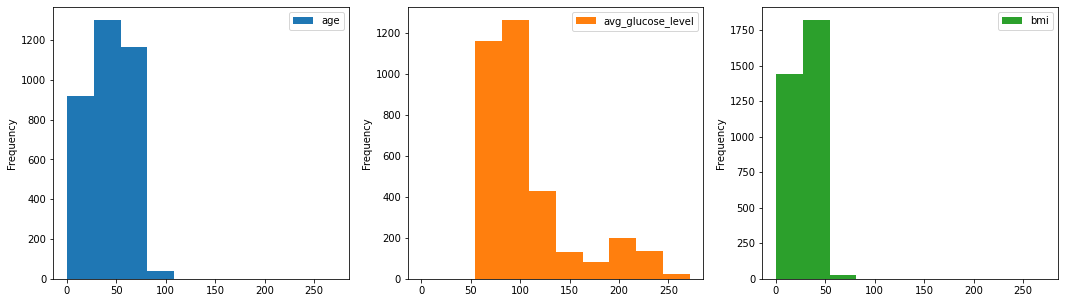

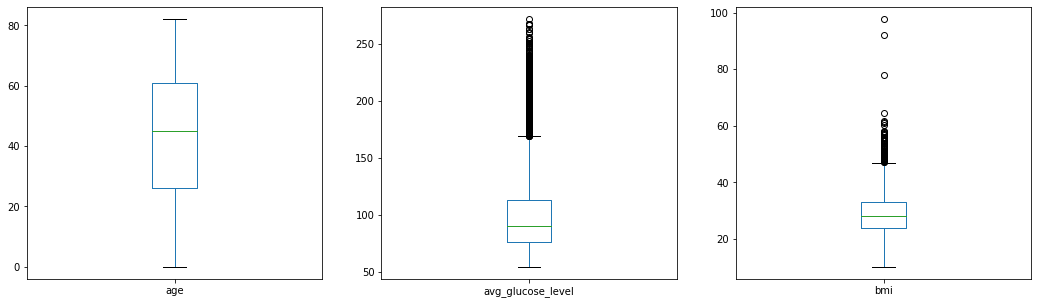

,age,avg_glucose_level,bmi
count,3423.00000,3423.000000,3285.000000
mean,43.41532,105.673082,29.068919
std,22.43486,45.586165,7.841403
min,0.08000,55.120000,10.300000
25%,26.00000,76.465000,23.800000
50%,45.00000,91.040000,28.300000
75%,61.00000,113.660000,33.100000
max,82.00000,271.740000,97.600000


In [423]:
# histogram
train_set[numerical_ix].plot(kind='hist', subplots=True, layout=(1,3), figsize=(18, 5))
pyplot.show()

# box and whisker plot
train_set[numerical_ix].plot(kind='box', subplots=True, layout=(1,3), figsize=(18, 5))
pyplot.show()

# summarize
train_set[numerical_ix].describe()

By looking at the table and by research domain specific knowledge, we infer:

* *age* feature has outliers, where min value should be greater than or equal to 1
* *bmi* feature has outliers, where max value should not be far greater than 70

## 3. Strategy On Identifying Outliers

IMPORTANT: READ THIS: https://scikit-learn.org/stable/modules/outlier_detection.html

Select one of these following strategies

### Option 1: Identify Outlier With Standard Deviation

From histogram, we assume *bmi* have near-Gaussian distribution. So we can apply Standard Deviation method in defining outliers.

UPPER BOUND FOR BMI IS NOW: 59.795579237486876 WITH FACTOR 4 OF STD FROM MEAN
LOWER BOUND FOR AGE IS NOW: 1
> NUMBER OF OUTLIERS DETECTED: 34
> NUMBER OF REMAINING EXAMPLES: 3389


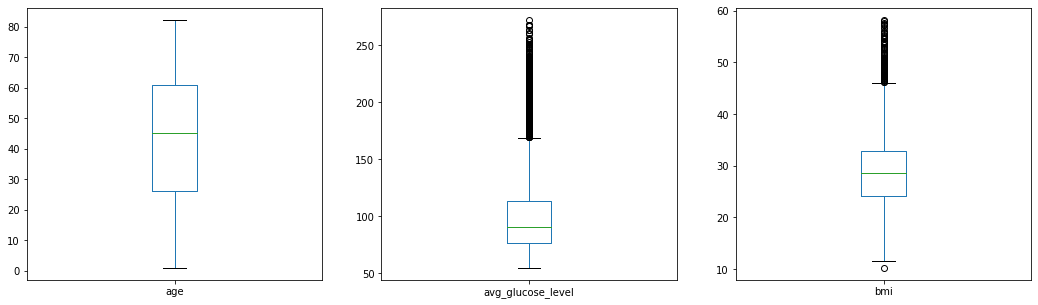

> THESE ARE OUTLIERS:


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
47350,Female,0.08,0,0,No,children,Urban,139.67,14.1,missing_value,0
67099,Male,0.56,0,0,No,children,Rural,57.02,20.7,missing_value,0
61511,Female,0.32,0,0,No,children,Rural,73.71,16.2,missing_value,0
23360,Male,0.80,0,0,No,children,Rural,114.54,15.1,missing_value,0
56714,Female,0.72,0,0,No,children,Rural,62.13,16.8,missing_value,0
54747,Male,0.88,0,0,No,children,Rural,157.57,19.2,missing_value,0
66772,Female,0.32,0,0,No,children,Rural,55.86,16.0,missing_value,0
29487,Male,0.72,0,0,No,children,Urban,80.08,16.4,missing_value,0
53126,Female,0.64,0,0,No,children,Urban,62.27,17.3,missing_value,0


In [410]:
bmi_mean, bmi_std = train_set["bmi"].mean(), train_set["bmi"].std()
# define outliers outside 4 factor of std from mean
factor = 4
cut_off = bmi_std * factor
bmi_upper = bmi_mean + cut_off
print("UPPER BOUND FOR BMI IS NOW:", bmi_upper, "WITH FACTOR", factor, "OF STD FROM MEAN")

age_lower = 1
print("LOWER BOUND FOR AGE IS NOW:", age_lower)

# identify non-outlier indexes
mask_outlier = (train_set["bmi"] > bmi_upper) | (train_set["age"] < age_lower)
mask_nonoutlier = mask_outlier == False

print("> NUMBER OF OUTLIERS DETECTED:", train_set[mask_outlier].shape[0])
print("> NUMBER OF REMAINING EXAMPLES:", train_set[mask_nonoutlier].shape[0])

# box and whisker plot
train_set[mask_nonoutlier][numerical_ix].plot(kind='box', subplots=True, layout=(1,3), figsize=(18, 5))
pyplot.show()

print("> THESE ARE OUTLIERS:")
train_set[mask_outlier]

### Option 2: Identify Outlier With Quantile Range

UPPER BOUND FOR BMI IS NOW: 70.30000000000001 WITH FACTOR 4 OF IQR
LOWER BOUND FOR AGE IS NOW: 1
> NUMBER OF OUTLIERS DETECTED: 29
> NUMBER OF REMAINING EXAMPLES: 3394


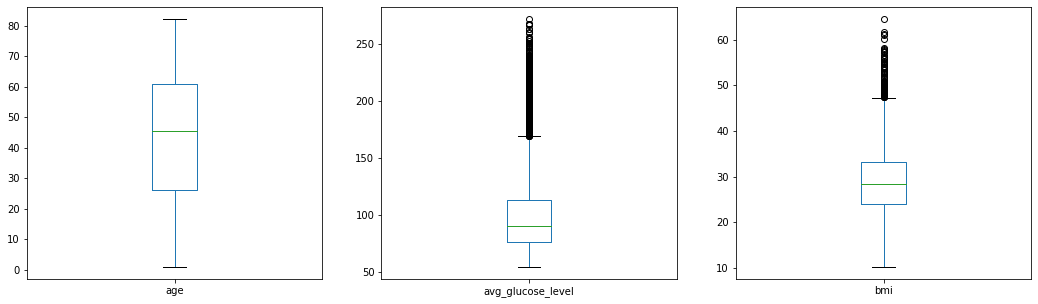

> THESE ARE OUTLIERS:


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
47350,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
67099,Male,0.56,0,0,No,children,Rural,57.02,20.7,Unknown,0
61511,Female,0.32,0,0,No,children,Rural,73.71,16.2,Unknown,0
23360,Male,0.80,0,0,No,children,Rural,114.54,15.1,Unknown,0
56714,Female,0.72,0,0,No,children,Rural,62.13,16.8,Unknown,0
54747,Male,0.88,0,0,No,children,Rural,157.57,19.2,Unknown,0
66772,Female,0.32,0,0,No,children,Rural,55.86,16.0,Unknown,0
29487,Male,0.72,0,0,No,children,Urban,80.08,16.4,Unknown,0
53126,Female,0.64,0,0,No,children,Urban,62.27,17.3,Unknown,0


In [424]:
q25, q75 = train_set['bmi'].quantile(0.25), train_set['bmi'].quantile(0.75)
iqr = q75 - q25
factor = 4
cut_off = iqr * factor
bmi_upper = q75 + cut_off
print("UPPER BOUND FOR BMI IS NOW:", bmi_upper, "WITH FACTOR", factor, "OF IQR")

age_lower = 1
print("LOWER BOUND FOR AGE IS NOW:", age_lower)

# identify non-outlier indexes
mask_outlier = (train_set["bmi"] > bmi_upper) | (train_set["age"] < age_lower)
mask_nonoutlier = mask_outlier == False

print("> NUMBER OF OUTLIERS DETECTED:", train_set[mask_outlier].shape[0])
print("> NUMBER OF REMAINING EXAMPLES:", train_set[mask_nonoutlier].shape[0])

# box and whisker plot
train_set[mask_nonoutlier][numerical_ix].plot(kind='box', subplots=True, layout=(1,3), figsize=(18, 5))
pyplot.show()

print("> THESE ARE OUTLIERS:")
train_set[mask_outlier]


### Option 3: Identify Outliers With Local Outlier Factor

Could not implement because categorical datatypes are not numeric.

## 4. Strategy On Handling Outliers

Select one of these following strategies

### Option 1: Remove Outliers

In [425]:
train_set = train_set[mask_nonoutlier].copy()

### Option 2: Replace With Missing Values

Not implemented yet

## 5. Mark Missing Values as NaN

In [426]:
def mark_missing(df):
    df["smoking_status"].replace('Unknown', nan, inplace=True)

print("> MARKED MISSING VALUES AS NaN On Both Training And Test Sets")
mark_missing(train_set)
mark_missing(test_set)

> MARKED MISSING VALUES AS NaN On Both Training And Test Sets


## 6. Strategies On Dealing With Missing Values

In [427]:
class MissingHandler:
    """Handle missing values in the DataFrame.
    
    Methods:
        __ini__(method='impute')
            method: string 'impute' or 'drop'
            
        fit(X)
            Set up imputation or drop strategy for later use.
            
            X: Pandas DataFrame
            
        transform(X, inplace=False)
            X: Pandas DataFrame
            
            inplace: boolean, default=False
                if True, do drop NaN inplace.
                
            return new DataFrame whether inplace=True or not.
            
        info(X)
            X: Pandas DataFrame
    """
    
    def __init__(self, method='impute'):
        self.method = method
        self.imputers = None
        self.miss_cols = None
        
    def fit(self, X):
        if self.method == 'impute':
            self.miss_cols = []
            self.imputers = None

            for col in X.columns:
                n_miss = X[col].isnull().sum()
                if n_miss > 0:
                    self.miss_cols.append(col)
                
            self.imputers = {col: SimpleImputer(strategy=('constant' if col in categorical_ix else 'mean')) for col in self.miss_cols}    
            for col in self.miss_cols:
                before = X[col].values.reshape(-1, 1)
                self.imputers[col].fit(before)
                
    def transform(self, X, inplace=False):
        new = X.copy()
        if self.method == 'impute':
            for col in self.miss_cols:
                before = X[col].values.reshape(-1, 1)
                after = self.imputers[col].transform(before)
                if inplace:
                    X[col] = pd.DataFrame(after, index=X.index, columns=[col])
                else:
                    new[col] = pd.DataFrame(after, index=X.index, columns=[col])
            return new
        elif self.method == 'drop':
            if inplace:
                X.dropna(inplace=True)
            else:
                return new.dropna()
        
    def missing_columns(self):
        return self.miss_cols[:]
    
    def info(self, X):
        cols = []
        for col in X.columns:
            n_miss = X[col].isnull().sum()
            if n_miss > 0:
                cols.append(col)
                
        print("> Total Number Of Missing Values:", X.isnull().sum().sum())
        print("  {:<20}{:>10}{:>15}".format("Features", "n_miss", "Percentage"))
        print("------------------------------------------------")
        for col in cols:
            n_miss = X[col].isnull().sum()
            perc = n_miss/X.shape[0] * 100
            print("> {:<20}{:>10}{:>15.1f}%".format(col, n_miss, perc))

Select one of these following strategies

### Option 1: Remove Rows With Missing Values

In [ ]:
m = MissingHandler(method='drop')

### Option 2: Impute With `SimpleImputer`

In [429]:
m = MissingHandler(method='impute')

After selecting either Option 1 or Option 2, run the following cell.

In [432]:
print("> Training set:")
m.info(train_set)

print("> Test set:")
m.info(test_set)

m.fit(train_set)

m.transform(train_set, inplace=True)
m.transform(test_set, inplace=True)

print("> After Processing Missing data...")

print("> Training set:")
m.info(train_set)

print("> Test set:")
m.info(test_set)

> Training set:
> Total Number Of Missing Values: 1148
  Features                n_miss     Percentage
------------------------------------------------
> bmi                        138            4.1%
> smoking_status            1010           29.8%
> Test set:
> Total Number Of Missing Values: 570
  Features                n_miss     Percentage
------------------------------------------------
> bmi                         63            3.7%
> smoking_status             507           30.1%
> After Processing Missing data...
> Training set:
> Total Number Of Missing Values: 0
  Features                n_miss     Percentage
------------------------------------------------
> Test set:
> Total Number Of Missing Values: 0
  Features                n_miss     Percentage
------------------------------------------------


### Option 3: Impute With KNN Imputation

Could not implemented because categorical features are not numeric.

### Option 4: Impute With Iterative Imputation

Could not implemented because categorical features are not numeric.

# 7. Prepare For Data Transformation

Before moving to the next steps of Data Transformation, we split training set and test set into X and y.

In [449]:
X_train, y_train = train_set[features].copy(), train_set[target].copy()
X_test, y_test = test_set[features].copy(), test_set[target].copy()

## Distinguish Nominal And Ordinal Data

From the name and unique values of each categorial feature listed above, it's intuitive to label all of them as nominal, but we will do some experiments with ordinal treatment later on.

In [435]:
ordinal_ix = []
nominal_ix = categorical_ix[:]

# 8. Select Strategy for Data Transformation

## 8.1 With Numerical Features

* Option 1: Normalization
* Option 2: Standardization
* Option 3: Change distribution to normal or near-normal
* Option 4: Discretize to Categorical Data
> As far as we know, *age* and *bmi* can be separated into 4 groups each:
>* *age*:
>>* Under 14: Children
>>* 15-24: Youth
>>* 25-64: Adults
>>* 65 and over: Senior
>* *bmi*:
>>* Below 18.5: Underweight
>>* 18.5 – 24.9:	Norma
>>* 25.0 – 29.9:	Overweight
>>* 30.0 and Above: Obese
>
> In addition, blood sugar levels can also be splitted into 4 group, though normal sugar level depends on each specific age group:
>>* Fasting
>>* Before meal
>>* 1-2 hours after eating
>?* Bedtime 

## 8.2 Encode Categorial Features

* Option 1: Convert to ordinal data
* Option 2: Convert to nominal data

Now, select one of the following strategies below.

In [296]:
print("> NUMERICAL FEATURES ARE NORMALIZED TO THE RANGE (0, 1)")
print("> CATEGORIAL FEATURES ARE ENCODED TO ORDINAL DATA")
ct = ColumnTransformer([('scale', MinMaxScaler(), numerical_ix),
                        ('encode', OrdinalEncoder(), categorical_ix)],
                        remainder='passthrough')
ct.fit(X_train)

In [265]:
print("> NUMERICAL FEATURES ARE NORMALIZED TO THE RANGE (0, 1)")
print("> CATEGORIAL FEATURES ARE ENCODED TO NOMINAL DATA")
ct = ColumnTransformer([('scale', MinMaxScaler(), numerical_ix),
                        ('encode', OneHotEncoder(handle_unknown='ignore'), categorical_ix)],
                        remainder='passthrough')
ct.fit(X_train)

In [304]:
print("> NUMERICAL FEATURES ARE STANDARDIZED TO CENTER AT 0 WITH STD = 1")
print("> CATEGORIAL FEATURES ARE ENCODED TO ORDINAL DATA")
ct = ColumnTransformer([('scale', StandardScaler(), numerical_ix),
                        ('encode', OrdinalEncoder(), categorical_ix)],
                        remainder='passthrough')
ct.fit(X_train)

In [ ]:
print("> NUMERICAL FEATURES ARE STANDARDIZED TO CENTER AT 0 WITH STD = 1")
print("> CATEGORIAL FEATURES ARE ENCODED TO NOMINAL DATA")
ct = ColumnTransformer([('scale', StandardScaler(), numerical_ix),
                        ('encode', OneHotEncoder(handle_unknown='ignore'), categorical_ix)],
                        remainder='passthrough')
ct.fit(X_train)

In [322]:
print("> NUMERICAL FEATURES ARE CHANGED TO NORMAL DISTRIBUTION")
print("> CATEGORIAL FEATURES ARE ENCODED TO ORDINAL DATA")
ct = ColumnTransformer([('power', QuantileTransformer(output_distribution='normal'), numerical_ix),
                        ('encode', OrdinalEncoder(), categorical_ix)],
                        remainder='passthrough')
ct.fit(X_train)

In [450]:
print("> NUMERICAL FEATURES ARE CHANGED TO NORMAL DISTRIBUTION")
print("> CATEGORIAL FEATURES ARE ENCODED TO NOMINAL DATA")
ct = ColumnTransformer([('power', QuantileTransformer(output_distribution='normal'), numerical_ix),
                        ('encode', OneHotEncoder(handle_unknown='ignore'), categorical_ix)],
                        remainder='passthrough')
ct.fit(X_train)

> NUMERICAL FEATURES ARE CHANGED TO NORMAL DISTRIBUTION
> CATEGORIAL FEATURES ARE ENCODED TO NOMINAL DATA


ColumnTransformer(remainder='passthrough',
                  transformers=[('power',
                                 QuantileTransformer(output_distribution='normal'),
                                 ['age', 'avg_glucose_level', 'bmi']),
                                ('encode',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['gender', 'hypertension', 'heart_disease',
                                  'ever_married', 'work_type', 'Residence_type',
                                  'smoking_status'])])

In [296]:
print("> NUMERICAL FEATURES ARE DISCRETIZED TO NORMAL DISTRIBUTION")
print("> CATEGORIAL FEATURES ARE ENCODED TO ORDINAL DATA")
ct = ColumnTransformer([('discr', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans'), numerical_ix),
                        ('encode', OrdinalEncoder(), categorical_ix)],
                        remainder='passthrough')
ct.fit(X_train)

In [329]:
print("> NUMERICAL FEATURES ARE DISCRETIZED TO NORMAL DISTRIBUTION")
print("> CATEGORIAL FEATURES ARE ENCODED TO NOMINAL DATA")
ct = ColumnTransformer([('discr', KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='kmeans'), numerical_ix),
                        ('encode', OneHotEncoder(handle_unknown='ignore'), categorical_ix)],
                        remainder='passthrough')
ct.fit(X_train)

## 8.3 Setup Encoder For Target Variable

In [437]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

LabelEncoder()

# 9. Perform Data Transformation

> Histogram of age


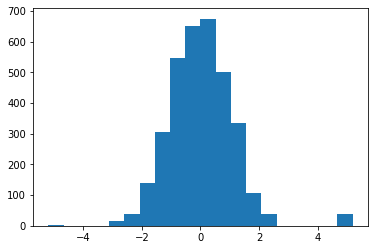

> Histogram of avg_glucose_level


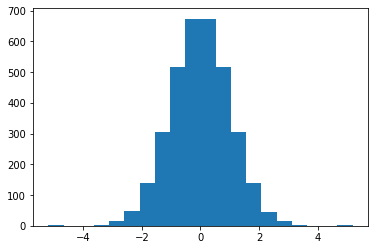

> Histogram of bmi


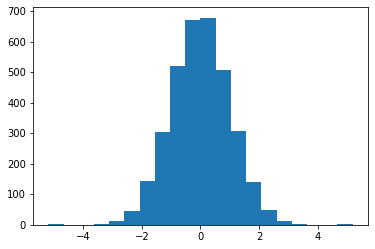

In [451]:
X_train = ct.transform(X_train)
y_train = label_encoder.transform(y_train)

X_test = ct.transform(X_test)
y_test = label_encoder.transform(y_test)



for col in range(len(numerical_ix)):
    print("> Histogram of", numerical_ix[col])
    pyplot.hist(X_train[:, col], bins=20)
    pyplot.show()

# 10. Write Prepared Data Onto Files

In [454]:
train = np.hstack((X_train, y_train.reshape(-1, 1)))
np.savetxt("prepared_training_set.csv", train, delimiter=',')

test = np.hstack((X_test, y_test.reshape(-1, 1)))
np.savetxt("prepared_test_set.csv", test, delimiter=',')